# Random Survival Forests

In [197]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.impute import SimpleImputer 

# Подготовка данных

In [261]:
df = pd.read_csv("data.csv", delimiter=",")
df['gender'] = df['gender'].map({'мужской': 0, 'женский': 1})

df = df.drop('bmi', axis=1)
df = df.drop('EGFR', axis=1)
df = df.drop('ALK/ROS1', axis=1)
df = df.drop('PD-L1', axis=1)

label_encoder = LabelEncoder()

label_encoder.fit(df['stage']) 
df['stage'] = label_encoder.transform(df['stage'])

label_encoder.fit(df['t']) 
df['t'] = label_encoder.transform(df['t'])

label_encoder.fit(df['n']) 
df['n'] = label_encoder.transform(df['n'])

label_encoder.fit(df['m']) 
df['m'] = label_encoder.transform(df['m'])

In [262]:
array = df.values
X = array[:,2:]
y = array[:,:2]

In [263]:
y[:,1], y[:,0] = y[:,0].copy(), y[:,1].copy()

In [264]:
df

,surv_time,death,gender,age_first,stage,t,n,m,line1,line2,line3,line4,line_ad,line_neoad,no_line
0,524,False,1,67.0,2,5,0,0,False,False,False,False,False,False,True
1,709,False,1,51.0,9,5,3,0,False,False,False,False,False,False,True
2,496,False,1,80.0,3,5,0,0,False,False,False,False,False,False,True
3,358,False,1,68.0,11,7,2,2,False,False,False,False,False,False,True
4,217,False,1,73.0,0,8,2,2,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3595,142,False,0,59.0,10,7,2,0,False,False,False,False,False,False,True
3596,454,False,0,63.0,10,7,3,0,False,False,False,False,False,False,True
3597,148,False,0,70.0,10,7,3,0,False,False,False,False,False,False,True
3598,874,False,1,29.0,5,4,0,0,False,False,False,False,False,False,True


In [265]:
dt = dtype = [('Status', '?'), ('Survival_in_days', '<f8')]
y = np.array([tuple(i) for i in y], dtype=dt)

In [266]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.20, random_state=1)

# Определим значимость признаков

In [283]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(rsf, n_iter=15, random_state=1)
perm.fit(X_test, Y_test)
eli5.show_weights(perm, feature_names=list(df.columns[2:]))

Weight,Feature
0.0451 ± 0.0240,m
0.0367 ± 0.0170,n
0.0321 ± 0.0069,age_first
0.0206 ± 0.0112,t
0.0100 ± 0.0091,stage
0.0049 ± 0.0049,no_line
0.0034 ± 0.0035,gender
0.0016 ± 0.0021,line1
0.0000 ± 0.0000,line_ad
0 ± 0.0000,line_neoad


# Penalized Cox Models

In [255]:
from sksurv.linear_model import CoxPHSurvivalAnalysis, CoxnetSurvivalAnalysis
from sksurv.preprocessing import OneHotEncoder

from sklearn.model_selection import GridSearchCV, KFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

In [248]:
alphas = 10. ** np.linspace(-4, 4, 50)
coefficients = {}

cph = CoxPHSurvivalAnalysis()
for alpha in alphas:
    cph.set_params(alpha=alpha)
    cph.fit(X, y)
    key = round(alpha, 5)
    coefficients[key] = cph.coef_

coefficients = (pd.DataFrame.from_dict(coefficients).rename_axis(index="feature", columns="alpha").set_index(df.columns[2:]))

In [251]:
def plot_coefficients(coefs, n_highlight):
    _, ax = plt.subplots(figsize=(9, 6))
    n_features = coefs.shape[0]
    alphas = coefs.columns
    for row in coefs.itertuples():
        ax.semilogx(alphas, row[1:], ".-", label=row.Index)

    alpha_min = alphas.min()
    top_coefs = coefs.loc[:, alpha_min].map(abs).sort_values().tail(n_highlight)
    for name in top_coefs.index:
        coef = coefs.loc[name, alpha_min]
        plt.text(
            alpha_min, coef, name + "   ",
            horizontalalignment="right",
            verticalalignment="center"
        )

    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    ax.grid(True)
    ax.set_xlabel("alpha")
    ax.set_ylabel("coefficient")

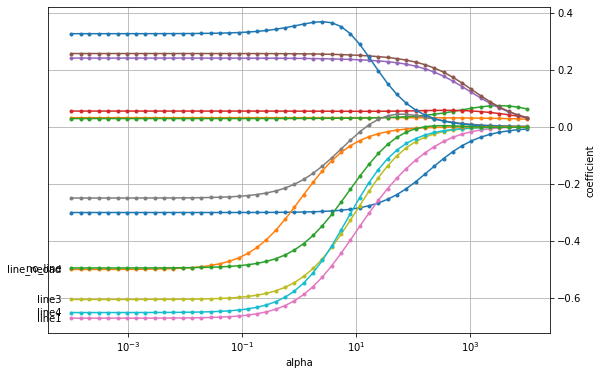

In [252]:
plot_coefficients(coefficients, n_highlight=5)

# Using Random Survival Forests

In [267]:
rsf = RandomSurvivalForest(n_estimators=1000, min_samples_split=10, min_samples_leaf=15,
                           max_features="sqrt", n_jobs=-1, random_state=1)
rsf.fit(X_train, Y_train)

RandomSurvivalForest(max_features='sqrt', min_samples_leaf=15,
                     min_samples_split=10, n_estimators=1000, n_jobs=-1,
                     random_state=1)

In [269]:
rsf.score(X_test, Y_test)

0.7170966970478038

In [272]:
a = np.empty(X_test.shape[0], dtype=[("age", float), ("stage", float)])
a["age"] = X_test[:, 0]
a["stage"] = X_test[:, 4]

sort_idx = np.argsort(a, order=["stage", "age"])
X_test_sel = pd.DataFrame(
    X_test[np.concatenate((sort_idx[:3], sort_idx[-3:]))],
    columns=df.columns[2:])

X_test_sel

,gender,age_first,stage,t,n,m,line1,line2,line3,line4,line_ad,line_neoad,no_line
0,0,81.0,5,5,0,0,False,False,False,False,False,False,True
1,0,76.0,3,5,0,0,False,False,False,False,False,False,True
2,0,62.0,5,5,0,0,False,False,False,False,False,False,True
3,1,71.0,11,7,3,2,False,False,False,False,False,False,True
4,1,65.0,9,5,3,0,False,False,False,False,False,False,True
5,1,33.0,11,6,3,3,False,False,False,False,False,False,True


In [273]:
pd.Series(rsf.predict(X_test_sel))

0     91.875625
1     57.283042
2     64.398618
3    255.228975
4    124.057448
5    206.964685
dtype: float64

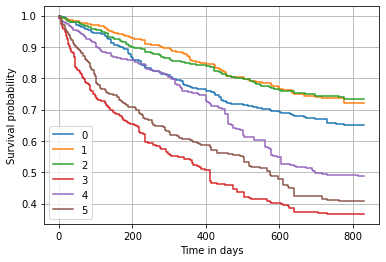

In [274]:
surv = rsf.predict_survival_function(X_test_sel, return_array=True)

for i, s in enumerate(surv):
    plt.step(rsf.event_times_, s, where="post", label=str(i))
plt.ylabel("Survival probability")
plt.xlabel("Time in days")
plt.legend()
plt.grid(True)

# Gradient Boosted Models

In [285]:
from sklearn.model_selection import train_test_split
from sksurv.datasets import load_breast_cancer
from sksurv.ensemble import ComponentwiseGradientBoostingSurvivalAnalysis
from sksurv.ensemble import GradientBoostingSurvivalAnalysis
from sksurv.preprocessing import OneHotEncoder

In [287]:
est_cph_tree = GradientBoostingSurvivalAnalysis(
    n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0
)
est_cph_tree.fit(X_train, Y_train)
cindex = est_cph_tree.score(X_test, Y_test)
print(round(cindex, 3))

0.72


In [289]:
scores_cph_tree = {}

est_cph_tree = GradientBoostingSurvivalAnalysis(
    learning_rate=1.0, max_depth=1, random_state=0
)
for i in range(1, 31):
    n_estimators = i * 5
    est_cph_tree.set_params(n_estimators=n_estimators)
    est_cph_tree.fit(X_train, Y_train)
    scores_cph_tree[n_estimators] = est_cph_tree.score(X_test, Y_test)

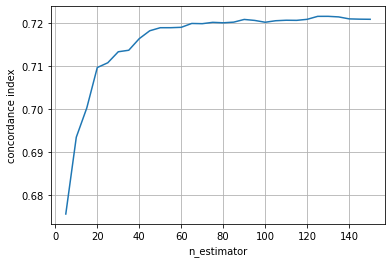

In [290]:
x, y = zip(*scores_cph_tree.items())
plt.plot(x, y)
plt.xlabel("n_estimator")
plt.ylabel("concordance index")
plt.grid(True)